#  Edge Graph Convolutional NN for  Jet tagging using jet constituents from HLS data using node self-reccurrence

This NN is inspired by Dynamic Graph CNN for Learning on Point Clouds (DGCNN) but uses only a single Conv1D layer to get an embedded respresentation for points and edges and applies a MLP to classify the Graph based on embbeded representation. It can be extended adding more Conv1D and new KNN graphs defined on embedded spaces , but we didn't do it because the NN gets too large for HLS L1 trigger aplications  

## Author: Andre Sznajder


## Inspired by:

`Jet Tagging via Particle Clouds by Huilin Qu & Loukas Gouskos` ( https://arxiv.org/pdf/1902.08570.pdf )
https://github.com/hqucms/ParticleNet/blob/master/tf-keras/tf_keras_model.py

`Particle NET for Particle Characterization`
https://github.com/pnnl/particle-net

`Dynamic Graph CNN for Learning on Point Clouds (DGCNN)` 
https://github.com/WangYueFt/dgcnn/tree/master/tensorflow

## Also inspired by SPEKTRAL implementation which uses a MLP instead of CONV:
Both aproaches are equivalent when using aplying convolution on each node individually
https://graphneural.network/layers/convolution/#edgeconv



# Load HLS4ML dataset 

## Here, we load the numpy arrays containing the 4D tensors of "jet-images" (see https://arxiv.org/pdf/1511.05190.pdf)

## https://github.com/pierinim/tutorials/blob/master/GGI_Jan2021/Lecture1/Notebook1_ExploreDataset.ipynb

 * 'jetImage' contains the image representation of the jets (more later)

 * 'jetImageECAL' and 'jetImageHCAL' are the ECAL- and HCAL-only equivalent images. We will not use them (but you are more than welcome to play with it)

 * 'jetConstituentList' is the list of particles cointained in the jet. For each particle, a list of relevant quantities is stored

 * 'particleFeatureNames' is the list of the names corresponding to the quantities contained in 'jetConstituentList' 'jets' is the dataset we consider for the moment

 * 'jetFeatureNames' is the list of the names corresponding to the quantities contained in 'jets'


In [1]:
import numpy as np
import h5py
import os

# for pT, eta_rel, phi_rel
#   myJetConstituentList = np.array(f.get("jetConstituentList")[:,:,[5,8,11]])
# for px, py, pz
#   myJetConstituentList = np.array(f.get("jetConstituentList")[:,:,[0,1,2]])
#   myJetConstituentList = np.array(f.get("jetConstituentList"))
#
# Jet Constituents Features =  [0='j1_px', 1='j1_py', 2='j1_pz', 3='j1_e', 4='j1_erel', 5='j1_pt', 6='j1_ptrel',
#                         7='j1_eta', 8='j1_etarel', 9='j1_etarot', 10='j1_phi', 11='j1_phirel', 12='j1_phirot',
#                         13='j1_deltaR', 14='j1_costheta', 15='j1_costhetarel', 16='j1_pdgid']



#Data PATH
TRAIN_PATH = '/Users/sznajder/WorkM1/workdir/data/hls4ml_LHCjet_150p_train/'

# Prepare the DATA
#target = np.array([])
#jetConstituent = np.array([])
#jetImage = np.array([])
first=True
for file in os.listdir(TRAIN_PATH):
  print("Appending %s" %file)

  with h5py.File(TRAIN_PATH+file, 'r') as data:
    if first : 
        first=False
        jetConstituent = data['jetConstituentList'][:,:,[5,8,11]]  # 
#        jetImage= data['jetImage'][:,:,:] 
        target = data['jets'][:,-6:-1]
    
        print("Keys in H5PY files = ",list( data.keys() ))
        print(" ")
        featurenames = data.get('jetFeatureNames')
        print("Jets Features = ",featurenames[:])
        # the b is due to the byte vs utf-8 encoding of the strings in the dataset
        # just ignore them for the moment
        print(" ")
        featurenames = data.get('particleFeatureNames')
        print("Jet Constituents Features = ",featurenames[:])
        print(" ")
        images = data.get('jetImage')
        print("Jet Images = ",images[:])        
        print("Jet Image Shape = ",images.shape)   
        print(" ")

    else:
         # Read (Pt,Etarel,Phirel)
        jetConstituent = np.concatenate( [ jetConstituent, data['jetConstituentList'][:,:,[5,8,11]] ] , axis=0 )
         # Read (Pt,Eta,Phi)
#        jetConstituent = np.concatenate( [ jetConstituent, data['jetConstituentList'][:,:,[5,7,10]] ] , axis=0 )
#        jetImage = np.concatenate( [ jetImage, data['jetImage']    ] , axis=0 )
        target   = np.concatenate( [ target, data['jets'][:,-6:-1] ] , axis=0 )



                                    
print("Target shape =", target.shape)
print("Jet Constituents shape =", jetConstituent.shape)
print("Jet Constituents type =", type(jetConstituent))
#print("Jet Image shape =", jetImage.shape)


Appending jetImage_6_150p_40000_50000.h5
Keys in H5PY files =  ['jetConstituentList', 'jetFeatureNames', 'jetImage', 'jetImageECAL', 'jetImageHCAL', 'jets', 'particleFeatureNames']
 
Jets Features =  [b'j_ptfrac' b'j_pt' b'j_eta' b'j_mass' b'j_tau1_b1' b'j_tau2_b1'
 b'j_tau3_b1' b'j_tau1_b2' b'j_tau2_b2' b'j_tau3_b2' b'j_tau32_b1'
 b'j_tau32_b2' b'j_zlogz' b'j_c1_b0' b'j_c1_b1' b'j_c1_b2' b'j_c2_b1'
 b'j_c2_b2' b'j_d2_b1' b'j_d2_b2' b'j_d2_a1_b1' b'j_d2_a1_b2' b'j_m2_b1'
 b'j_m2_b2' b'j_n2_b1' b'j_n2_b2' b'j_tau1_b1_mmdt' b'j_tau2_b1_mmdt'
 b'j_tau3_b1_mmdt' b'j_tau1_b2_mmdt' b'j_tau2_b2_mmdt' b'j_tau3_b2_mmdt'
 b'j_tau32_b1_mmdt' b'j_tau32_b2_mmdt' b'j_c1_b0_mmdt' b'j_c1_b1_mmdt'
 b'j_c1_b2_mmdt' b'j_c2_b1_mmdt' b'j_c2_b2_mmdt' b'j_d2_b1_mmdt'
 b'j_d2_b2_mmdt' b'j_d2_a1_b1_mmdt' b'j_d2_a1_b2_mmdt' b'j_m2_b1_mmdt'
 b'j_m2_b2_mmdt' b'j_n2_b1_mmdt' b'j_n2_b2_mmdt' b'j_mass_trim'
 b'j_mass_mmdt' b'j_mass_prun' b'j_mass_sdb2' b'j_mass_sdm1'
 b'j_multiplicity' b'j_g' b'j_q' b'j_w' b'j_z' b'

# The image dataset

Jets can be converted to images considering the (&eta;, &phi;) plane, centered along the axis direction and binned.
In our case, we consider a square of 1.6x1.6 in size (because the jet size is R=0.8) binned in 100x100 equal-size 'cells'


# The ground truth is incorporated in the ['g', 'q', 'w', 'z', 't'] vector of boolean, taking the form
 
## [1, 0, 0, 0, 0] for gluons
 
## [0, 1, 0, 0, 0] for quarks
 
## [0, 0, 1, 0, 0] for Ws
 
## [0, 0, 0, 1, 0] for Zs
 
## [0, 0, 0, 0, 1] for tops

## This is what is called 'one-hot' encoding of a descrete label (typical of ground truth for classification problems)



# Filter out Pt<2GeV constituents and set MAX number of constituents in dataset

In [2]:
from einops import rearrange, reduce, repeat

# Convert target format from one-hot encoding to single neuron
#target = np.argmax(target, axis=1)

# The dataset is N_jets x N_constituents x N_features
njet     = jetConstituent.shape[0]
nconstit = jetConstituent.shape[1]
nfeat    = jetConstituent.shape[2]

# Filter out constituents with Pt<2GeV
Ptmin =2. 
constituents = np.zeros((njet, nconstit, nfeat) , dtype=np.float32) 
ij=0
max_constit=0
for j in range(njet):
    ic=0
    for c in range(nconstit):
        if ( jetConstituent[j,c,0] < Ptmin ):
            continue
        constituents[ij,ic,:] = jetConstituent[j,c,:] 
        ic+=1
    if (ic > 0):
        if ic > max_constit: max_constit=ic
        target[ij,:]=target[j,:] # assosicate the correct target a given graph 
        ij+=1


# Resizes the jets constituents and target arrays        
jetConstituent = constituents[0:ij,0:max_constit,:]
target = target[0:ij,:]


# Restric the number of constituents to a maximum of NMAX
nmax = 8
jetConstituent = jetConstituent[:,0:nmax,:]

# The dataset is N_jets x N_constituents x N_features
njet     = jetConstituent.shape[0]
nconstit = jetConstituent.shape[1]
nfeat    = jetConstituent.shape[2]


print('Number of jets =',njet)
print('Number of constituents =',nconstit)
print('Number of features =',nfeat)

Number of jets = 620000
Number of constituents = 8
Number of features = 3


## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing) 

In [3]:
from sklearn.model_selection import train_test_split

X = jetConstituent
Y = target
del jetConstituent
del target

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

#print(X_train_val.shape, X_test.shape, A_train_val.shape, A_test.shape, Y_train_val.shape, Y_test.shape)

print('number of G jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==0 ))
print('number of Q jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==1 ))
print('number of W jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==2 ))
print('number of Z jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==3 ))
print('number of T jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==4 ))

print('number of G jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==0 ))
print('number of Q jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==1 ))
print('number of W jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==2 ))
print('number of Z jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==3 ))
print('number of T jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==4 ))



number of G jets for training/validation: 83689
number of Q jets for training/validation: 80676
number of W jets for training/validation: 83507
number of Z jets for training/validation: 83589
number of T jets for training/validation: 83939
number of G jets for testing: 41159
number of Q jets for testing: 39535
number of W jets for testing: 41430
number of Z jets for testing: 41065
number of T jets for testing: 41411


## Define KNN algorithm to find nearest node neightbours 

In [4]:
import tensorflow as tf
from tensorflow import keras


# A shape is (N, P_A, C), B shape is (N, P_B, C)
# D shape is (N, P_A, P_B)
def batch_distance_matrix_general(A, B):
    with tf.name_scope('dmat'):
        r_A = tf.reduce_sum(A * A, axis=2, keepdims=True)
        r_B = tf.reduce_sum(B * B, axis=2, keepdims=True)
        m = tf.matmul(A, tf.transpose(B, perm=(0, 2, 1)))
        D = r_A - 2 * m + tf.transpose(r_B, perm=(0, 2, 1))
        return D


def knn(num_points, k, topk_indices, features):
    # topk_indices: (N, P, K)
    # features: (N, P, C)
    with tf.name_scope('knn'):
        queries_shape = tf.shape(features)
        batch_size = queries_shape[0]
        batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, num_points, k, 1))
        indices = tf.concat([batch_indices, tf.expand_dims(topk_indices, axis=3)], axis=3)  # (N, P, K, 2)
        return tf.gather_nd(features, indices)


def knn_diff(X,K):
    """EdgeConv
    Args:
        K: int, number of neighbors
    Inputs:
        X: point features (eta, phi, Pt)
    Returns:
        neighbours features differences
    """

    # Define node coordinates and features ( original ParticleNET uses only Pt as node features ! )
    pts = X[:,:,1:3] # (Eta,Phi) coordinates of points ( graph nodes )
    fts = X          # (Pt,Eta,Phi) node features ( graph node features )
    num_points = X.shape[1]

    # distance
    D = batch_distance_matrix_general(pts, pts)  # (N, P, P)
    _, indices = tf.nn.top_k(-D, k=K + 1)  # (N, P, K+1)
    indices = indices[:, :, 1:]  # (N, P, K)

    # Finds nodes nearest neighbours features differences
    knn_fts = knn(num_points, K, indices, fts)  # (N, P, K, C)
    knn_fts_center = tf.tile(tf.expand_dims(fts, axis=2), (1, 1, K, 1))  
    knn_fts = tf.subtract(knn_fts, knn_fts_center)  # (N, P, K, C)

    return knn_fts



## Define EdgeGraphConv Model 

EdgeGraphConv implements a modified version of DGCNN where we use a Conv1D instead of a Conv2D in order to define the convolution over the graph nodes and edges. Notice that a Conv1D layer uses a kernel_size=1 and stride=1 over the nodes(edges), so it's equivalent to apply a MLP to agregate the  nodes(edges) features. In Spektral EdgeConv uses directly an MLP for that. 

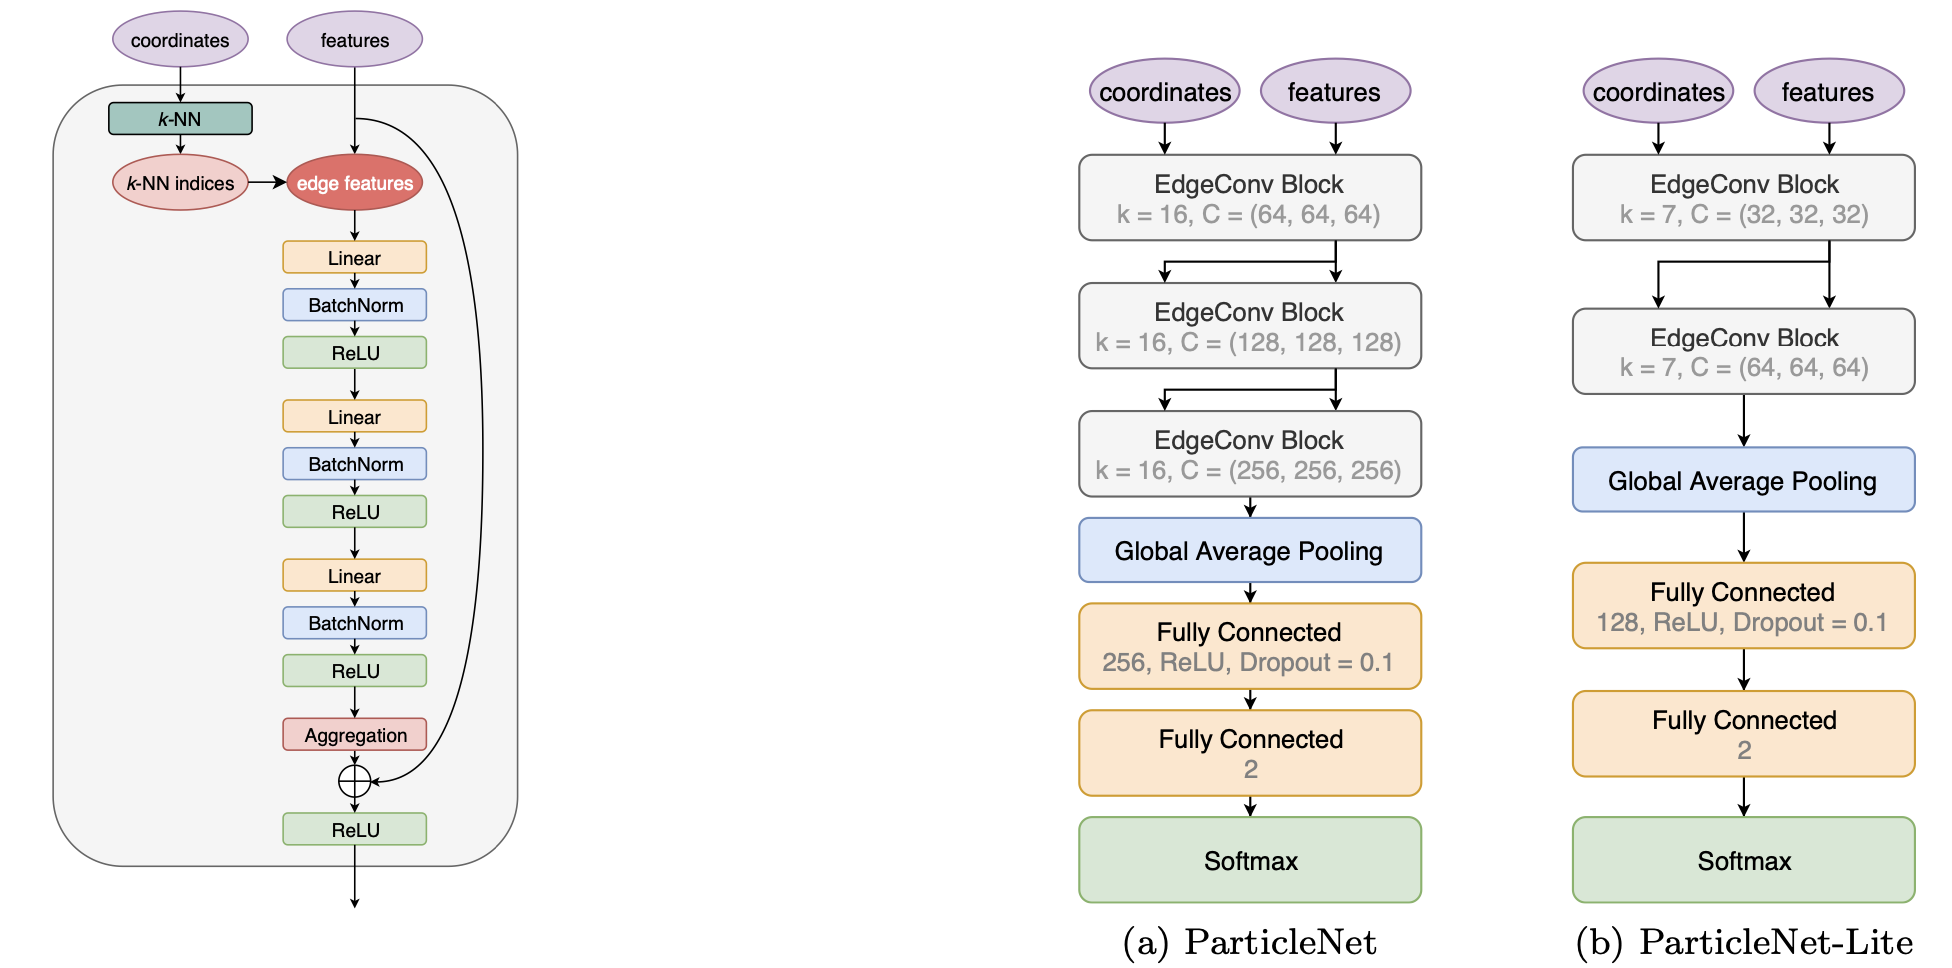


In [6]:
# baseline keras model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.layers import BatchNormalization, MaxPool1D, Conv1D
from tensorflow.keras.layers import Input, Activation, Dense, Flatten 
from tensorflow.keras import utils

###########################################################################
# Define DynamicGraphConv Model 

'''
# For 32 constituents
point_channels=8   
edge_channels = 2  
nhidden = int(nconstit*nfeat/2) 
k=4                
'''

'''
# For 16 constituents
point_channels=16                 
edge_channels = 4   
nhidden = int(nconstit*nfeat/3.) 
k=8                 
'''

#'''
# For 8 constituents
point_channels = 20   
edge_channels  = 20   
nhidden = int(nconstit*nfeat/2) 
k=7                   
#'''

##############################################################################
ntargets = 5

# Instantiate Tensorflow input tensors in Batch mode 
in_points = Input(shape=(nconstit,nfeat), name="in_points")

# Input point features BatchNormalization 
h = BatchNormalization(name='BatchNorm_points')(in_points)

# Conv1D with kernel_size=nfeatures to implement a MLP like aggregation of 
#   input point features ( pt, eta_rel, phi_rel)
'''
h_points = Conv1D(point_channels, kernel_size=nfeat, strides=nfeat
                  , activation="relu"
                  , use_bias="True"
                  , name='Conv1D_points')(h)
'''

h_points = Conv1D(point_channels, kernel_size=1, strides=1
                  , activation="relu"
                  , use_bias="True"
                  , name='Conv1D_points')(h)

# Instantiate Tensorflow input tensors in Batch mode 
in_edges = Input(shape=(nconstit,k*nfeat), name="in_edges")


# Input edges features BatchNormalization 
h = BatchNormalization(name='BatchNorm_edges')(in_edges)

# Conv1D with kernel_size=nfeatures to implement a MLP, taking neighbouring nodes 
#   features differences as edges features 
'''
h_edges  = Conv1D(edge_channels, kernel_size=nfeat, strides=nfeat
                  , activation="relu"
                  , use_bias="True"
                  , name='Conv1D_edges')(h)
'''

h_edges  = Conv1D(edge_channels, kernel_size=1, strides=1
                  , activation="relu"
                  , use_bias="True"
                  , name='Conv1D_edges')(h)

# Concatenate points+edge features                           
#        out = Activation(activation, name='Activation_features')(sc + fts)  # (N, P, C')
#        out = sc+fts
h = tf.concat([h_points,h_edges],axis=2)

# reshape into MLP input (batch, nconstit*(point + edge channels))
#h = tf.reshape(h,[-1,nconstit*(point_channels+edge_channels)]) 

# Flatten to format for MLP input
h=Flatten(name='Flatten')(h)
print("MLP input h =",h)

# Dense layers for classification
h = Dense(nhidden, activation='relu')(h)
#h = Dense(nconstit*nfeat/8, activation='relu')(h)
out = Dense(ntargets, activation='softmax')(h)  # (N, num_classes)

# Build the model
model = Model(inputs=[in_points,in_edges], outputs=out)

# Define the optimizer ( minimization algorithm )
#optim = SGD(learning_rate=0.0001,decay=1e-6)
optim = Adam(learning_rate=0.0005)
#optim = Adam(learning_rate=0.0002)
#optim = Adam()


# Compile the Model
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# print the model summary
model.summary()


MLP input h = KerasTensor(type_spec=TensorSpec(shape=(None, 320), dtype=tf.float32, name=None), name='Flatten/Reshape:0', description="created by layer 'Flatten'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_points (InputLayer)          [(None, 8, 3)]       0                                            
__________________________________________________________________________________________________
in_edges (InputLayer)           [(None, 8, 21)]      0                                            
__________________________________________________________________________________________________
BatchNorm_points (BatchNormaliz (None, 8, 3)         12          in_points[0][0]                  
__________________________________________________________________________________________________
BatchNorm_edges (BatchNormali

## Run training
Here, we run the training.

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# early stopping callback
es = EarlyStopping(monitor='val_categorical_accuracy', patience=10)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into mlp_model.h5
chkp = ModelCheckpoint('EdgeGraphConv_model.h5', monitor='val_categorical_accuracy', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)

#tb = TensorBoard("/Users/sznajder/WorkM1/miniforge3/tensorflow_macos/arm64/workdir/logs")

# Train classifier
point_feats = X_train_val
diffs = knn_diff(X_train_val,k) # (batch,constit,k_neighbour,feat_diff)
edge_feats = tf.reshape(diffs,[-1,nconstit,k*nfeat])   # reshape edges (N,nconstit*K*nfeat)
#targets = tf.expand_dims(Y_train_val,axis=1)
targets = Y_train_val



print("point_feats shape= ",point_feats.shape)
print("edge_feats shape= ",edge_feats.shape)
print("Y_train_val shape= ",Y_train_val.shape)


history = model.fit(  [point_feats, edge_feats] , targets, 
                    epochs=100, 
                    batch_size=512, 
                    verbose=1,
                    callbacks=[es,ls,chkp],
                    validation_split=0.3 )
                    
#                    callbacks=[early_stopping, model_checkpoint], 
                    

point_feats shape=  (415400, 8, 3)
edge_feats shape=  (415400, 8, 21)
Y_train_val shape=  (415400, 5)
Epoch 1/100
568/568 [==============================] - 1s 2ms/step - loss: 1.3679 - categorical_accuracy: 0.4295 - val_loss: 1.2706 - val_categorical_accuracy: 0.4904
Epoch 2/100
568/568 [==============================] - 1s 2ms/step - loss: 1.1790 - categorical_accuracy: 0.5474 - val_loss: 1.1342 - val_categorical_accuracy: 0.5711
Epoch 3/100
568/568 [==============================] - 1s 2ms/step - loss: 1.1117 - categorical_accuracy: 0.5767 - val_loss: 1.0958 - val_categorical_accuracy: 0.5871
Epoch 4/100
568/568 [==============================] - 1s 2ms/step - loss: 1.0865 - categorical_accuracy: 0.5885 - val_loss: 1.0792 - val_categorical_accuracy: 0.5904
Epoch 5/100
568/568 [==============================] - 1s 2ms/step - loss: 1.0710 - categorical_accuracy: 0.5951 - val_loss: 1.0650 - val_categorical_accuracy: 0.5982
Epoch 6/100
568/568 [==============================] - 1s 2ms/s

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

shape Y_predict = (204600, 5)


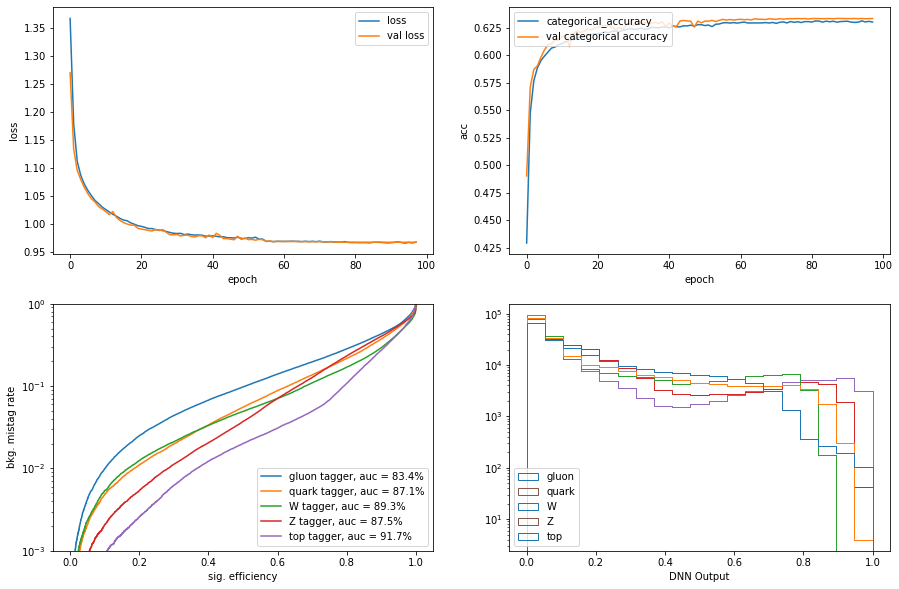

In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


#plt.rcParams['axes.unicode_minus'] = False

# Plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# Plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
#ax.plot(history.history['accuracy'], label='accuracy')
#ax.plot(history.history['val_accuracy'], label='val accuracy')
ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot the ROC curves
labels = ['gluon', 'quark', 'W', 'Z', 'top']
fpr = {}
tpr = {}
auc1 = {}
ax = plt.subplot(2, 2, 3)

point_feats = X_test
diffs = knn_diff(X_test,k) # (batch,constit,k_neighbour,feat_diff)
edge_feats = tf.reshape(diffs,[-1,nconstit,k*nfeat])   # reshape edges (N,nconstit*K*nfeat)

Y_predict = model.predict([point_feats,edge_feats])
print("shape Y_predict =",Y_predict.shape)

for i, label in enumerate(labels):
#        fpr[label], tpr[label], threshold = roc_curve(Y_test[:,i], Y_predict[:,0,i])
        fpr[label], tpr[label], threshold = roc_curve(Y_test[:,i], Y_predict[:,i])

        auc1[label] = auc(fpr[label], tpr[label])
        ax.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
ax.semilogy()
ax.set_xlabel("sig. efficiency")
ax.set_ylabel("bkg. mistag rate")
ax.set_ylim(0.001,1)
#ax.set_grid(True)
ax.legend(loc='lower right')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))



# Plot DNN output 
ax = plt.subplot(2, 2, 4)
X = np.linspace(0.0, 1.0, 20)
hist={}
for i, name in enumerate(labels):
#    hist[name] = ax.hist(Y_predict[:,0,:], bins=X, label=name ,histtype='step')

    hist[name] = ax.hist(Y_predict[:,:], bins=X, label=name ,histtype='step')

ax.semilogy()
ax.set_xlabel('DNN Output')
ax.legend(prop={'size': 10})
ax.legend(loc='lower left')
# Display plots
plt.show()


In [9]:
# Save FPR for a given TPR value ( 30% , 50% & 80%)
with open('/Users/sznajder/WorkM1/workdir/data/performance_EdgeGraphConv_nconst_'+str(nmax)+'.csv', 'w') as file:
  file.write("model,label,treshold,tpr,fpr\n")
  for label in labels:
    for t in [0.3, 0.5, 0.8]:
      index = np.argmax(tpr[label]>t)
      file.write( model+','+label+','+str(t)+','+str(tpr[label][index])+','+str(fpr[label][index])+'\n' )
      print("Label = ", label , " with treshold = ",t)
      print("TPR = ",tpr[label][index])
      print("FPR = ",fpr[label][index])
      print(" ")
 

TypeError: unsupported operand type(s) for +: 'Functional' and 'str'